### Simple Linear Regression
Probabilistically, linear regression model can be expressed as :
$$ y \sim N(\mu = \alpha + \beta x, \sigma = \epsilon) $$

Since we do not know, values of parameters, $\alpha, \beta $ and $\epsilon $ we have to put a prior for these.
$$ \alpha \sim N(\mu_{\alpha}, \sigma_{\alpha}) $$
$$ \beta \sim N(\mu_{\beta}, \sigma_{\beta}) $$
$$ \epsilon \sim U(0, h_s) $$ 

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pymc3 as pm

In [2]:
import seaborn as sns

Text(0.5, 0, '$y$')

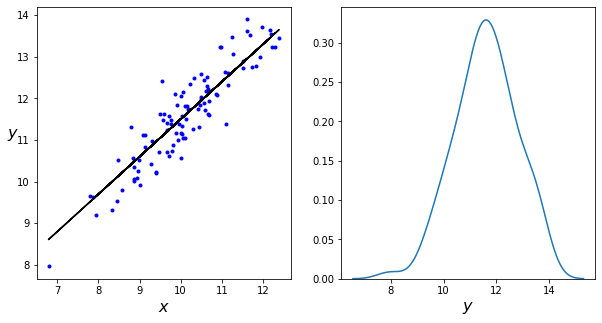

In [3]:
np.random.seed(314)
N = 100
alpha_real = 2.5
beta_real = 0.9
eps_real = np.random.normal(0, 0.5, size=N)

x = np.random.normal(10, 1, N)
y_real = alpha_real + beta_real * x
y = y_real + eps_real

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(x, y, 'b.')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation = 0)
plt.plot(x, y_real, 'k')
plt.subplot(1,2,2)
sns.kdeplot(y)
plt.xlabel('$y$', fontsize=16)

In [4]:
# lets build model with pm
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)
    
    # mu is deterministic variable in this model, hence
    mu = pm.Deterministic('mu', alpha + beta * x)
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(10000, step, start)

logp = -71.578, ||grad|| = 0.14936: 100%|██████████| 36/36 [00:00<00:00, 265.62it/s]         
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [epsilon]
>Metropolis: [beta]
>Metropolis: [alpha]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:05<00:00, 3861.68draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


In [7]:
# alternatively we can write as
# y_pred = pm.Normal('y_pred', mu = alpha + beta * x, sd = epsilon, observed = y)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2cc4101320>,
      dtype=object)

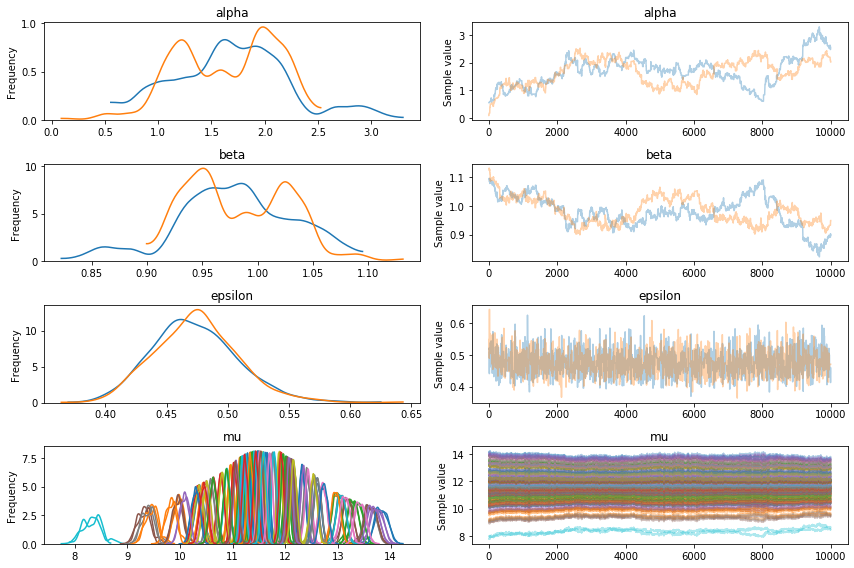

In [5]:
pm.traceplot(trace)

Traceplot is not looking very convincing. Plot for alpha and beta is going up and down, lets see the autocorrelation plot. As visible below, we have alot of autocorrelation for alpha and beta.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2cbf138e80>,
      dtype=object)

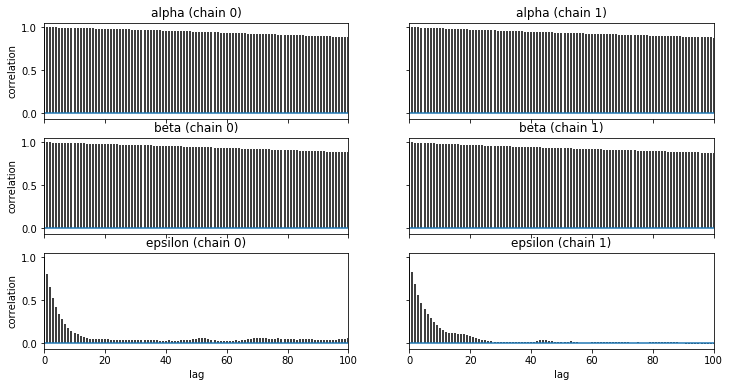

In [6]:
pm.autocorrplot(trace, ['alpha', 'beta', 'epsilon'])

### Linear Model and High Correlation
No matter which line we fit in our data, all of them should pass for one point, the mean of the x variable and mean of the y varaible. Hence the line-fitting process is somehow equivalent to spinning a strainght line fixed at the center of the data. An increase in the slope means decrease of the intercept and other way around. Bth parameters are going to be correlated by the definitions of the model. We can see if we plot the posterior.


Text(0, 0.5, '$\\beta$')

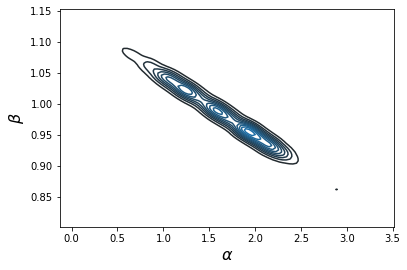

In [7]:
sns.kdeplot(trace['alpha'], trace['beta'])
plt.xlabel(r'$\alpha$', fontsize=16)
plt.ylabel(r'$\beta$', fontsize=16)

For algorithms such as Metropolis-Hastings, this can be very propblematic. Because if we propose large steps for individula parameters, most of the propsed values will fall outside of this high probability zone; if we propse small steps, they will need to be very small to accept them. Either way we get high autocorrelation in the sampling process and a very poor mixing.

### Modifying the data before running
One simple solution to our problem is to center the x data. For each $x_i$ data point, we subtract the mean of the x variable:
$$ x' = x - \overline{x}$$

As a result , x' will be centered at 0, and hence the pivot point when changing the slope is the intercept. 
Other thiing is standardizing it before running models. Standardizing is a common practice for linear regression models in ML/stats since many algorithms behave better when the data is stadardized. 
$$ x' = \frac{x - \overline{x}}{sd} $$

### Changing the sampling method
Another aproach to reduce autocorrelation is changing sampling method. NUTS has fewer difficulties that Metropolis in sampling such restricted diagonal space. The reason being NUTS moves according to the curvature of the posterior and hence easier for it to move along a diagonal space. 

In [9]:
# lets build model with pm
with pm.Model() as model_nuts:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)
    
    # mu is deterministic variable in this model, hence
    mu = pm.Deterministic('mu', alpha + beta * x)
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
    
    #start = pm.find_MAP()
    trace = pm.sample(10000, step, start)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [epsilon]
>>Metropolis: [beta]
>>Metropolis: [alpha]
>NUTS: [epsilon, beta, alpha]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:45<00:00, 465.87draws/s]


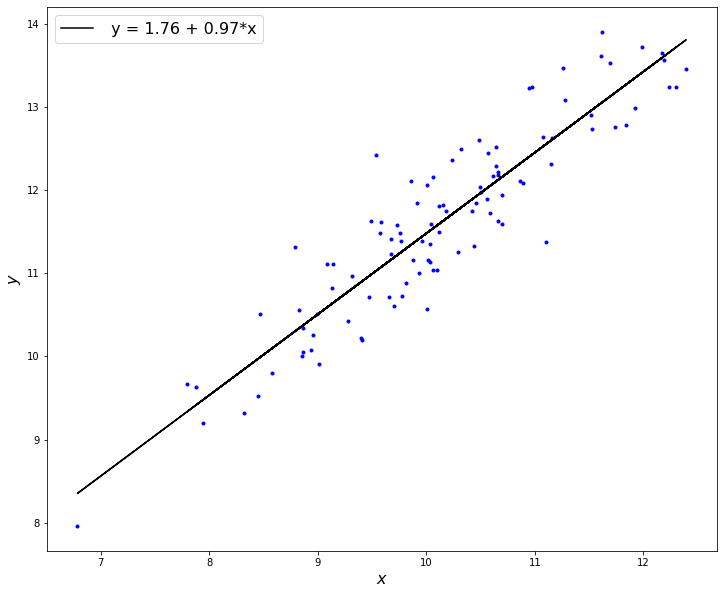

In [13]:
plt.figure(figsize=(12, 10))
plt.plot(x, y, 'b.')
alpha_m = trace['alpha'].mean()
beta_m = trace['beta'].mean()
plt.plot(x, alpha_m+ beta_m*x , c = 'k', label = ' y = {:.2f} + {:.2f}*x'.format(alpha_m, beta_m))
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16)
plt.legend(loc=2, fontsize=16)

### Posterior Uncertainty Plot

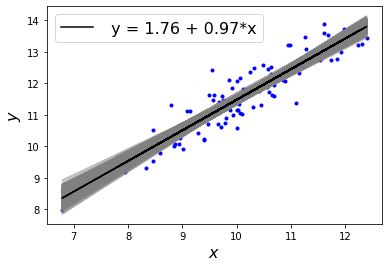

In [15]:
plt.plot(x, y, 'b.')
idx = range(0, len(trace['alpha']), 10)
#alpha_m = trace['alpha'].mean()
#beta_m = trace['beta'].mean()
plt.plot(x, trace['alpha'][idx] + trace['beta'][idx]*x[:, np.newaxis], c='gray', alpha=0.5)
plt.plot(x, alpha_m+ beta_m*x , c = 'k', label = ' y = {:.2f} + {:.2f}*x'.format(alpha_m, beta_m))
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16)
plt.legend(loc=2, fontsize=16)

### Pearson Correlation Coefficient
It is measure of linear correlation between two varibales, denoted by $r$. When value of $r$ is $+1$ we have a perfect positive linear correlation. When $r$ is $0$, we have no linear correlation. 
$$ r = \beta \frac{\sigma(x)}{\sigma(y)} $$

determination coefficient is $r^2$.